# Predicting car prices

This project will use various K-nearest neighbours workflows to predict car prices using a dataset containing specs of 205 unique car models.

dataset can be found at: https://archive.ics.uci.edu/ml/datasets/automobile

We will aim to initially develop a simple univariate model with a fixed neighbour count (default k=5) before moving on to univariate with variable k and finally moving to a more complex multivariate model.

Before building model we will start by looking at the dataset and cleaning it if necessary.

## Introduction to the Dataset

In [128]:
import pandas as pd

cars = pd.read_csv('imports-85.data')
cars.describe()

,3,88.60,168.80,64.10,48.80,2548,130,9.00,21,27
count,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
mean,0.823529,98.806373,174.075000,65.916667,53.749020,2555.602941,126.892157,10.148137,25.240196,30.769608
std,1.239035,5.994144,12.362123,2.146716,2.424901,521.960820,41.744569,3.981000,6.551513,6.898337
min,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,7.000000,13.000000,16.000000
25%,0.000000,94.500000,166.300000,64.075000,52.000000,2145.000000,97.000000,8.575000,19.000000,25.000000
50%,1.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,119.500000,9.000000,24.000000,30.000000
75%,2.000000,102.400000,183.200000,66.900000,55.500000,2939.250000,142.000000,9.400000,30.000000,34.500000
max,3.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,23.000000,49.000000,54.000000


In [129]:
cars.head(3)

,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.60,...,130,mpfi,3.47,2.68,9.00,111,5000,21,27,13495
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
1,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
2,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950


It appears that the dataset does not have any headers, we can manually find these from documentation and input them.

In [130]:
# manually inputting column headers
cols = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

In [131]:
cars = pd.read_csv('imports-85.data', names=cols)

In [132]:
cars.head(5)

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


We can only use numerical features to train our KNN algorithm, checking to see which columns are suitable

In [133]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
symboling            205 non-null int64
normalized-losses    205 non-null object
make                 205 non-null object
fuel-type            205 non-null object
aspiration           205 non-null object
num-of-doors         205 non-null object
body-style           205 non-null object
drive-wheels         205 non-null object
engine-location      205 non-null object
wheel-base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb-weight          205 non-null int64
engine-type          205 non-null object
num-of-cylinders     205 non-null object
engine-size          205 non-null int64
fuel-system          205 non-null object
bore                 205 non-null object
stroke               205 non-null object
compression-rate     205 non-null float64
horsepower           205 non-nul

Of these car attributes, the numeric ones are:

- normalized-losses
- wheel base
- length 
- width
- height
- curb weight
- engine-size
- bore
- stroke
- compression-rate
- horsepower
- peak RPM
- city-mpg
- highway-mpg
- price

Some of these columns are of the wrong type however e.g horsepower and will need to be cleaned. Lets first remove the non numeric columns.

In [134]:
# Keeping only numeric attributes
cont_values_cols = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
numeric_cars = cars[cont_values_cols]

## Data Cleaning

Predictive modelling can't have any missing values, will check to see which columns have missing values and will deal with the corresponing rows accordingly.

The preview shows multiple entries with '?' value, this also is why some columns are object type instead of float/int. Will replace '?' with nan.

In [135]:
import numpy as np

# removing '?', replacing with NaN
numeric_cars = numeric_cars.replace('?', np.nan)
numeric_cars.head()

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,NaN,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495
1,NaN,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500
2,NaN,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500
3,164,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950
4,164,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450


In [136]:
# converting columns to correct type, checking for nulls
numeric_cars = numeric_cars.astype('float')
numeric_cars.isnull().sum()

normalized-losses    41
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-size           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

As our model is looking to predict prices, the 4 entries with null prices will be removed.

In [137]:
# Removing entries with no price
numeric_cars = numeric_cars.dropna(subset=['price'])
numeric_cars.isnull().sum()

normalized-losses    37
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-size           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 0
dtype: int64

We have a few options we can use for the remaining missing values including removal. Instead we will replace the missing values with the mean for that attribute to avoid shrinking the dataset too much.

In [138]:
# replacing null values with the atribute mean
numeric_cars = numeric_cars.fillna(numeric_cars.mean())
numeric_cars.isnull().sum()

normalized-losses    0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-size          0
bore                 0
stroke               0
compression-rate     0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

Now we have cleaned the dataset, the final preliminary step is to normalize the numeric values (other than price) so they range from 0 - 1. 

In [139]:
# normalizing all columns except price
price_col = numeric_cars['price']
numeric_cars = (numeric_cars - numeric_cars.min()) / (numeric_cars.max() - numeric_cars.min())
numeric_cars['price'] = price_col

numeric_cars.head()

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474,13495.0
1,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474,16500.0
2,0.298429,0.230321,0.449254,0.444444,0.383333,0.517843,0.343396,0.100000,0.666667,0.1250,0.495327,0.346939,0.166667,0.263158,16500.0
3,0.518325,0.384840,0.529851,0.504274,0.541667,0.329325,0.181132,0.464286,0.633333,0.1875,0.252336,0.551020,0.305556,0.368421,13950.0
4,0.518325,0.373178,0.529851,0.521368,0.541667,0.518231,0.283019,0.464286,0.633333,0.0625,0.313084,0.551020,0.138889,0.157895,17450.0


## Univariate Model

To start with, we will use a simple univariate K-Nearest Neighbours model before moving on to more complicated variants.

In [140]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

def knn_train_test(train_col, target_col, df):
    
    # randomizes the index of the df to remove any dataset bias
    np.random.seed(1)
    random_index = np.random.permutation(df.index)
    rand_df = df.loc[random_index]
    
    # equally splitting df into train and testing sets
    final_train_index = int(len(rand_df) / 2)
    train_set = rand_df.iloc[0:final_train_index]
    test_set = rand_df.iloc[final_train_index:]
    
    # instantiate the class with default settings
    knn = KNeighborsRegressor()
    knn.fit(train_set[[train_col]], train_set[[target_col]])
    prediction = knn.predict(test_set[[train_col]])
    
    # calculating rms error
    mse = mean_squared_error(test_set[target_col], prediction)
    rmse = np.sqrt(mse)
    return rmse

In [141]:
test_1 = knn_train_test('length', 'price', numeric_cars)
print(test_1)

5427.2009608367125


We have successfully implemented a simple, univariate KNN model. Next step is to compare features (atributes) to see which has the lowest overall rms error and therefore gives the most accurate prediction.

In [142]:
# calculating the RMSE for each feature and sorting from smallest to largest
rmses = {}

features = numeric_cars.columns.tolist()
# removing the target column
features.remove('price')

# applies the model to each feature
for feature in features:
    rmse = knn_train_test(feature, 'price', numeric_cars)
    rmses[feature] = rmse

rmses_series = pd.Series(rmses)
rmses_series.sort_values()

engine-size          3238.462830
horsepower           4037.037713
curb-weight          4401.118255
highway-mpg          4630.026799
width                4704.482590
city-mpg             4766.422505
length               5427.200961
wheel-base           5461.553998
compression-rate     6610.812153
bore                 6780.627785
normalized-losses    7330.197653
peak-rpm             7697.459696
stroke               8006.529545
height               8144.441043
dtype: float64

With the default k value (k=5), engine size was the best performing feature. We cannot however assume that the default k value gives the best results. 

Will modify the function to accept k as an input and compare the accuracy of differing k values.

In [143]:
# function splits dataset, calculates rmse for a given feature for each k value in given list
def knn_train_test(train_col, target_col, df, k):
    
    # randomizes the index of the df to remove input bias
    np.random.seed(1)
    random_index = np.random.permutation(df.index)
    rand_df = df.loc[random_index]
    
    # equally splitting df into train and testing sets
    final_train_index = int(len(rand_df) / 2)
    train_set = rand_df.iloc[0:final_train_index]
    test_set = rand_df.iloc[final_train_index:]
    
    # for cycling through k values, dictionary to store RMSE for each parameter for each K.
    k_values = k
    k_rmses = {}
    
    for k in k_values:
        # instantiate the class with default settings
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_set[[train_col]], train_set[[target_col]])
        prediction = knn.predict(test_set[[train_col]])

        # calculating rms error for each value of k
        mse = mean_squared_error(test_set[target_col], prediction)
        rmse = np.sqrt(mse)
        k_rmses[k] = rmse
        
    return k_rmses

In [144]:
# applies the modified variable k model for each parameter except from the target column (price)

# k values to be used and dictionary to store the rmse for each parameter at each k value
k_values = [1,3,5,7,9]
k_rmse_results = {}

features = numeric_cars.columns.drop('price')
for feature in features:
    rmse = knn_train_test(feature, 'price', numeric_cars, k_values)
    k_rmse_results[feature] = rmse
    
k_rmse_results

{'normalized-losses': {1: 7846.750605148984,
  3: 7500.5698123109905,
  5: 7330.197653434445,
  7: 7756.421586234123,
  9: 7688.096096891432},
 'wheel-base': {1: 4493.734068810494,
  3: 5120.161506064513,
  5: 5461.553997873057,
  7: 5448.1070513823315,
  9: 5738.405685192312},
 'length': {1: 4628.45550121557,
  3: 5129.8358210721635,
  5: 5427.2009608367125,
  7: 5313.427720847974,
  9: 5383.054514833446},
 'width': {1: 4559.257297950061,
  3: 4606.413692169901,
  5: 4704.482589704386,
  7: 4571.485046194653,
  9: 4652.914172067787},
 'height': {1: 8904.04645636071,
  3: 8277.609643045525,
  5: 8144.441042663747,
  7: 7679.598124393773,
  9: 7811.03606291223},
 'curb-weight': {1: 5264.290230758878,
  3: 5022.318011757233,
  5: 4401.118254793124,
  7: 4330.608104418053,
  9: 4632.044474454401},
 'engine-size': {1: 3258.4861059962027,
  3: 2840.562805643501,
  5: 3238.4628296477176,
  7: 3563.086774256415,
  9: 3831.8244149840766},
 'bore': {1: 8602.58848450066,
  3: 6984.239489480916,


Interpreting these results is quite difficult, will plot features rmse as a function of k to help visualise them.

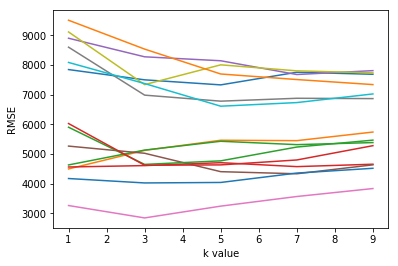

In [145]:
import matplotlib.pyplot as plt
%matplotlib inline

for k,feature in k_rmse_results.items():
    x = k_values
    y = list(feature.values())
    
    plt.plot(x,y)
    plt.xlabel('k value')
    plt.ylabel('RMSE')

There is a general trend that most parameters become more accurate as the k value initially increases before becoming less accurate as k continues to increase. This is a common phenomena in KNN.



## Multivariate Model

Now we will increase the complexity of model with the goal of improving accuracy by moving to a multivariate model. In order to know the best features to use, we will take the average rmse for each feature and keep the lowest 5.

In [146]:
feature_avg_rmse = {}
for k, feature in k_rmse_results.items():
    mean_rmse = np.mean(list(feature.values()))
    feature_avg_rmse[k] = mean_rmse
    
feature_series = pd.Series(feature_avg_rmse)
feature_series.sort_values()

engine-size          3346.484586
horsepower           4219.377860
width                4618.910560
curb-weight          4730.075815
highway-mpg          5069.469256
length               5176.394904
city-mpg             5202.409003
wheel-base           5252.392462
compression-rate     7166.073599
bore                 7222.472445
normalized-losses    7624.407151
stroke               8000.240467
peak-rpm             8119.365233
height               8163.346266
dtype: float64

We will compare the accuracy of using combinations of 2, 3, 4 and 5 of the best performing features from the univariate model. These features are:

- engine-size
- horsepower
- width
- curb-weight          
- highway-mpg


For now we will revert to a single k value (the default k=5)

In [147]:
def knn_train_test(features, target_col, df):
    
    # randomizes the index of the df to remove input bias
    np.random.seed(1)
    random_index = np.random.permutation(df.index)
    rand_df = df.loc[random_index]
    
    # equally splitting df into train and testing sets
    final_train_index = int(len(rand_df) / 2)
    train_set = rand_df.iloc[0:final_train_index]
    test_set = rand_df.iloc[final_train_index:]
    
    # instantiate the class with default settings
    knn = KNeighborsRegressor()
    knn.fit(train_set[features], train_set[[target_col]])
    prediction = knn.predict(test_set[features])
    
    # calculating rms error
    mse = mean_squared_error(test_set[target_col], prediction)
    rmse = np.sqrt(mse)
    return rmse

In [148]:
multi_variate_test = knn_train_test(['engine-size', 'horsepower'], 'price', numeric_cars)
print(multi_variate_test)

2949.8817277180374


In [149]:
top_two = ['engine-size', 'horsepower']
top_three = ['engine-size', 'horsepower', 'width']
top_four = ['engine-size', 'horsepower', 'width', 'curb-weight']
top_five = ['engine-size', 'horsepower', 'width', 'curb-weight', 'highway-mpg']

rmse_two = knn_train_test(top_two, 'price', numeric_cars)
rmse_three = knn_train_test(top_three, 'price', numeric_cars)
rmse_four = knn_train_test(top_four, 'price', numeric_cars)
rmse_five = knn_train_test(top_five, 'price', numeric_cars)

print(rmse_two, rmse_three, rmse_four, rmse_five)

2949.8817277180374 3580.7376651928435 3487.340917327035 3410.2170133901805


Looking at the RMSE values it is clear that the two feature model was the top performer. This may be somewhat surprising, it shows the importance of the quality of feature and not just the sheer number of features used.

## Hyperparameter tuning

We are now going to tune the hyperparameters for the top three performing models.
These are:

- top_two features
- top_five features
- top_four features

we are going to compare them by varying the k value from 1 - 25 for each model. We will then plot them to see which  had the lowest rmse and which k value was optimal for each model. 

In [156]:
# function splits dataset, calculates rmse for a given feature for each k value in given list
def knn_train_test(features, target_col, df, k):
    
    # randomizes the index of the df to remove input bias
    np.random.seed(1)
    random_index = np.random.permutation(df.index)
    rand_df = df.loc[random_index]
    
    # equally splitting df into train and testing sets
    final_train_index = int(len(rand_df) / 2)
    train_set = rand_df.iloc[0:final_train_index]
    test_set = rand_df.iloc[final_train_index:]
    
    # for cycling through k values, dictionary to store RMSE for each parameter for each K.
    k_values = [i for i in range(1,25)]
    k_rmses = {}
    
    for k in k_values:
        # instantiate the class with default settings
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_set[features], train_set[[target_col]])
        prediction = knn.predict(test_set[features])

        # calculating rms error for each value of k
        mse = mean_squared_error(test_set[target_col], prediction)
        rmse = np.sqrt(mse)
        k_rmses[k] = rmse
        
    return k_rmses

In [157]:
two_features_k = knn_train_test(top_two, 'price', numeric_cars, k)
five_features_k = knn_train_test(top_five, 'price', numeric_cars, k)
four_features_k = knn_train_test(top_four, 'price', numeric_cars, k)

print(two_features_k)
print(five_features_k)

{1: 2783.6204237227344, 2: 2657.7963807419765, 3: 2792.586573031673, 4: 2891.5329686923255, 5: 2949.8817277180374, 6: 3096.402601694776, 7: 3164.681969020496, 8: 3413.228359192009, 9: 3748.6716603306486, 10: 4080.7125057341937, 11: 4215.6372280600335, 12: 4275.421524277872, 13: 4373.901683035496, 14: 4424.285137239815, 15: 4539.505493095937, 16: 4667.307671446768, 17: 4729.605305844226, 18: 4790.556632159094, 19: 4824.3866193292615, 20: 4840.850914693829, 21: 4837.429062000271, 22: 4831.16988267597, 23: 4861.679492959275, 24: 4903.346008862579}
{1: 2824.7061233282866, 2: 2915.6731645496975, 3: 3012.4204546509704, 4: 3202.8876051367483, 5: 3410.2170133901805, 6: 3618.4509432660384, 7: 3622.6290209234803, 8: 3848.635835654326, 9: 3977.8149139381726, 10: 3994.8132211260104, 11: 4159.843526607947, 12: 4294.3389473154875, 13: 4380.848359486949, 14: 4466.368754416089, 15: 4522.420711094978, 16: 4536.427578452413, 17: 4587.098443664006, 18: 4622.107837952761, 19: 4612.890107622797, 20: 4632.6

We will plot these results on one graph to help visualise.

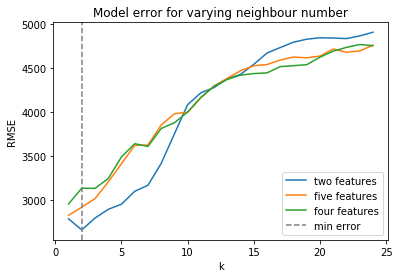

In [168]:
k_values = [i for i in range(1,25)]

plt.plot(k_values, two_features_k.values(), label='two features')
plt.plot(k_values, five_features_k.values(), label='five features')
plt.plot(k_values, four_features_k.values(), label='four features')
plt.xlabel('k')
plt.axvline(2, color='gray', label='min error', linestyle='--')
plt.ylabel('RMSE')
plt.title('Model error for varying neighbour number')
plt.legend()
plt.show()

From here it is clear that the two feature model outperforms the others at lower k values and also has the lowest overall RMSE at k = 2.

## Future improvements

We could include further analysis including using k-fold cross validation and make other improvements to the models by adding cleaning inside the function itself.